<a href="https://colab.research.google.com/github/notanikdey/SummerSchool/blob/main/maize_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
from google.colab import files
files.upload()  # Upload kaggle.json here manually

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anikdey23","key":"276468e06081ec71a35ec6aeb0dcb62d"}'}

In [13]:
import os
import zipfile

# Make .kaggle directory and move the file
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [14]:
!kaggle competitions download -c ssd-3-l-maiize-disease-classification

 62% 100M/161M [00:00<00:00, 1.04GB/s]
100% 161M/161M [00:00<00:00, 788MB/s] 


In [15]:
import zipfile

zip_path = "/content/ssd-3-l-maiize-disease-classification.zip"
extract_path = "/content/maize_leaf_disease_competition"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [12]:
os.listdir(extract_path)

['maize_dataset_split']

Original size: (256, 256)


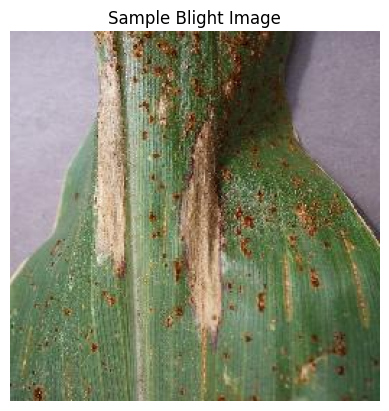

In [16]:
from PIL import Image

img_path = "maize_leaf_disease_competition/maize_dataset_split/train/Blight/Blight_00000.jpg"
img = Image.open(img_path)

print("Original size:", img.size)  # (width, height)

plt.imshow(img)
plt.title("Sample Blight Image")
plt.axis('off')
plt.show()


In [17]:
base_path = "/content/maize_leaf_disease_competition/maize_dataset_split"

In [23]:
#Loading the dataset and settin up the transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), #a diseased spot on either side should still be recognized
    transforms.RandomRotation(15), #for rotational invariance
    transforms.ColorJitter(brightness=0.2, contrast=0.2), #lighting variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3) #normalization to [-1,1]
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3) #normalization to [-1,1]
])

train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [53]:
class MaizeCNN(nn.Module):
  def __init__(self):
    super(MaizeCNN, self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 256x256
        nn.ReLU(),
        nn.MaxPool2d(2),  # → 128x128

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),  # → 64x64

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)   # → 32x32
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),  # 64 * 32 * 32 = 65536
        nn.Linear(64 * 32 * 32, 256),
        nn.ReLU(),
        nn.Linear(256, 4)  # 4 output classes
        )

  def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [54]:
model = MaizeCNN().to(device)

In [55]:
#Defining loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

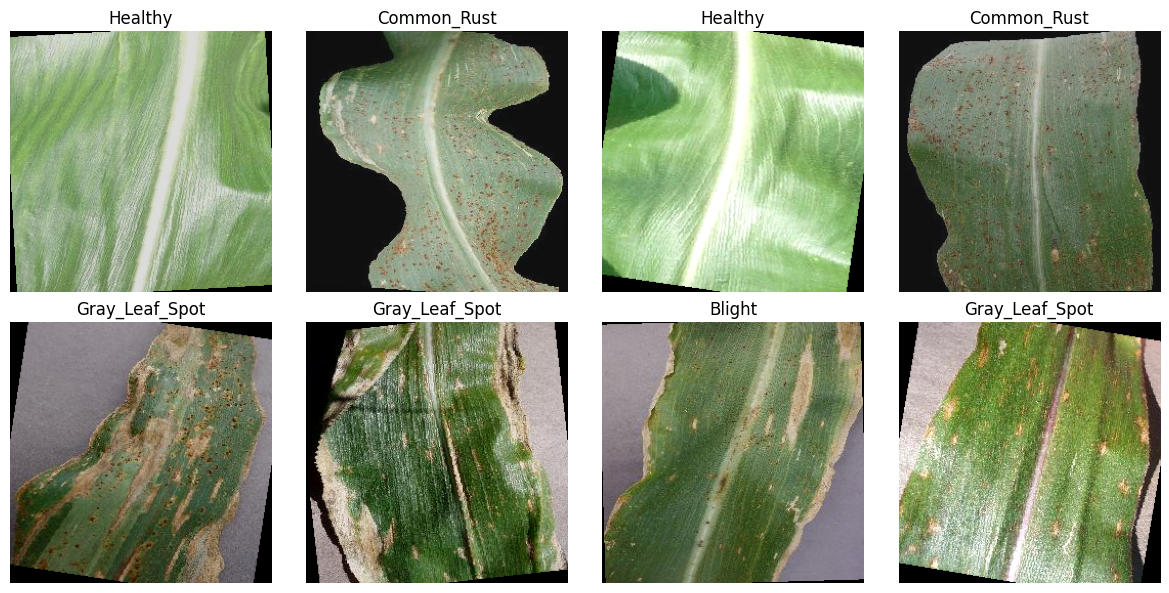

In [26]:
#Visualizing a batch

images, labels = next(iter(train_loader))

# Denormalize to [0, 1] range for visualization
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

class_names = train_dataset.classes

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(denormalize(images[i]).permute(1, 2, 0))  # C,H,W → H,W,C
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

Training and Validation Loop

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
import time

In [56]:

num_epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    start = time.time()

    #### TRAINING ####
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader) #for each batch/iteration
    train_losses.append(avg_train_loss)

    #### VALIDATION ####
    model.eval()
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Accuracy: {val_acc*100:.2f}% | "
          f"Time: {time.time() - start:.1f}s")


Epoch [1/10] | Train Loss: 0.7730 | Val Accuracy: 82.80% | Time: 19.4s
Epoch [2/10] | Train Loss: 0.4736 | Val Accuracy: 86.46% | Time: 19.1s
Epoch [3/10] | Train Loss: 0.3964 | Val Accuracy: 86.94% | Time: 19.9s
Epoch [4/10] | Train Loss: 0.3673 | Val Accuracy: 87.10% | Time: 18.7s
Epoch [5/10] | Train Loss: 0.3508 | Val Accuracy: 87.10% | Time: 19.9s
Epoch [6/10] | Train Loss: 0.3238 | Val Accuracy: 88.69% | Time: 18.8s
Epoch [7/10] | Train Loss: 0.3126 | Val Accuracy: 88.85% | Time: 19.6s
Epoch [8/10] | Train Loss: 0.2931 | Val Accuracy: 88.85% | Time: 18.6s
Epoch [9/10] | Train Loss: 0.2925 | Val Accuracy: 89.65% | Time: 19.9s
Epoch [10/10] | Train Loss: 0.2710 | Val Accuracy: 89.65% | Time: 19.2s


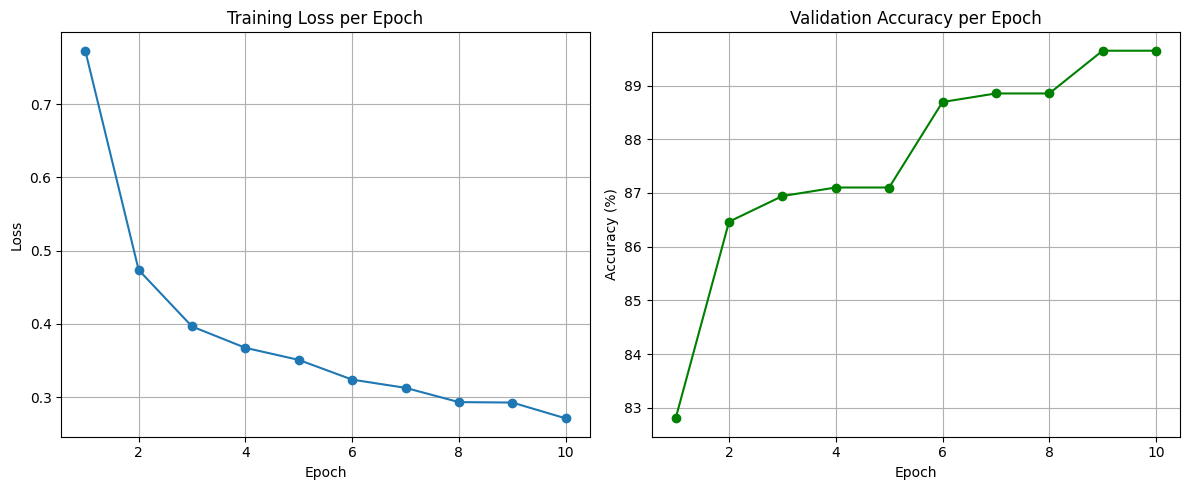

In [57]:
#Plotting the Losses
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in val_accuracies], marker='o', color='green')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [58]:
test_dir = os.path.join(base_path, "test")
print("Files in test dir:", os.listdir(test_dir))


Files in test dir: ['Common_Rust', 'Gray_Leaf_Spot', 'Blight', 'Healthy']


In [59]:
from torchvision import datasets

test_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


Test Accuracy: 86.65%

 Classification Report:
                precision    recall  f1-score   support

        Blight       0.75      0.88      0.81       172
   Common_Rust       0.94      0.89      0.91       196
Gray_Leaf_Spot       0.73      0.52      0.61        86
       Healthy       0.98      0.99      0.99       175

      accuracy                           0.87       629
     macro avg       0.85      0.82      0.83       629
  weighted avg       0.87      0.87      0.86       629



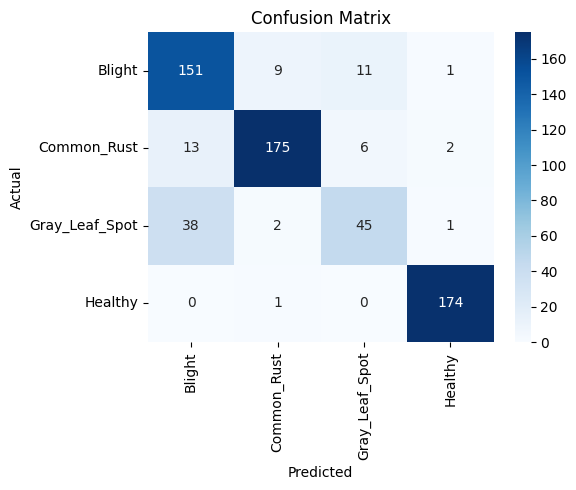

In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()
all_preds, all_labels = [], []

with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

#Mapping class indices to class names
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
pred_labels = [idx_to_class[p] for p in all_preds]
true_labels = [idx_to_class[t] for t in all_labels]

#Accuracy
acc = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {acc*100:.2f}%")

#Report
print("\n Classification Report:")
print(classification_report(true_labels, pred_labels))

#Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=test_dataset.classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [61]:
from glob import glob
import os

test_dir = os.path.join(base_path, 'test')
image_paths = sorted(glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True))
print(f"Found {len(image_paths)} test images.")

Found 629 test images.


In [62]:
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm

# Use the same test transform
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Map index → class label
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

results = []

model.eval()
with torch.inference_mode():
    for path in tqdm(image_paths):
        image = Image.open(path).convert('RGB')
        image = test_transform(image).unsqueeze(0).to(device)

        output = model(image)
        pred_idx = output.argmax(dim=1).item()
        pred_class = idx_to_class[pred_idx]

        filename = os.path.basename(path)
        results.append((filename, pred_class))


100%|██████████| 629/629 [00:03<00:00, 203.84it/s]


In [63]:
import pandas as pd
submission_df = pd.DataFrame(results, columns=['image_id', 'label'])
submission_df.to_csv("submission.csv", index=False)

In [64]:
!kaggle competitions submit -c ssd-3-l-maiize-disease-classification -f submission.csv -m "MaizeCNN submission"


100% 18.1k/18.1k [00:01<00:00, 10.3kB/s]
Successfully submitted to SSD3L:Maize_Disease_Classification

In [67]:
!kaggle competitions submissions -c ssd-3-l-maiize-disease-classification


fileName        date                        description                   status                     publicScore  privateScore  
--------------  --------------------------  ----------------------------  -------------------------  -----------  ------------  
submission.csv  2025-07-15 03:17:07.947000  MaizeCNN submission           SubmissionStatus.COMPLETE  0.00         0.86          
submission.csv  2025-07-15 02:52:08.003000  ResNet18 baseline submission  SubmissionStatus.COMPLETE  0.00         0.96          
